Inference using Clients from Fedcls

In [1]:
import sys
import importlib
sys.path.append(r"C:\Users\km_ka\Desktop\Demo\FL\Cls-Fed")  
import fedcls
import fed_utils
importlib.reload(fedcls) 
importlib.reload(fed_utils)

<module 'fed_utils' from 'C:\\Users\\km_ka\\Desktop\\Demo\\FL\\Cls-Fed\\fed_utils.py'>

In [45]:

load_dir = r"C:\Users\km_ka\Desktop\Demo\Dataset\Graphs_Fed"
load_test_dir = r"C:\Users\km_ka\Desktop\Demo\Dataset\Graphs_Fed\subgraphstest"
subgraphs_loaded=fed_utils.load_subgraphs(load_dir)
subgraphs_test_loaded=fed_utils.load_subgraphs(load_test_dir)

✔ Loaded subgraph 0: X shape (1510, 15, 6), A shape (15, 15)
✔ Loaded subgraph 1: X shape (1510, 21, 6), A shape (21, 21)
✔ Loaded subgraph 2: X shape (1510, 23, 6), A shape (23, 23)
✔ Loaded subgraph 3: X shape (1510, 26, 6), A shape (26, 26)
✔ Loaded subgraph 4: X shape (1510, 24, 6), A shape (24, 24)
✔ Loaded subgraph 5: X shape (1510, 23, 6), A shape (23, 23)
✔ Loaded subgraph 6: X shape (1510, 19, 6), A shape (19, 19)
✔ Loaded subgraph 7: X shape (1510, 28, 6), A shape (28, 28)
✔ Loaded subgraph 8: X shape (1510, 10, 6), A shape (10, 10)
✔ Loaded subgraph 0: X shape (377, 15, 6), A shape (15, 15)
✔ Loaded subgraph 1: X shape (377, 21, 6), A shape (21, 21)
✔ Loaded subgraph 2: X shape (377, 23, 6), A shape (23, 23)
✔ Loaded subgraph 3: X shape (377, 26, 6), A shape (26, 26)
✔ Loaded subgraph 4: X shape (377, 24, 6), A shape (24, 24)
✔ Loaded subgraph 5: X shape (377, 23, 6), A shape (23, 23)
✔ Loaded subgraph 6: X shape (377, 19, 6), A shape (19, 19)
✔ Loaded subgraph 7: X shape (3

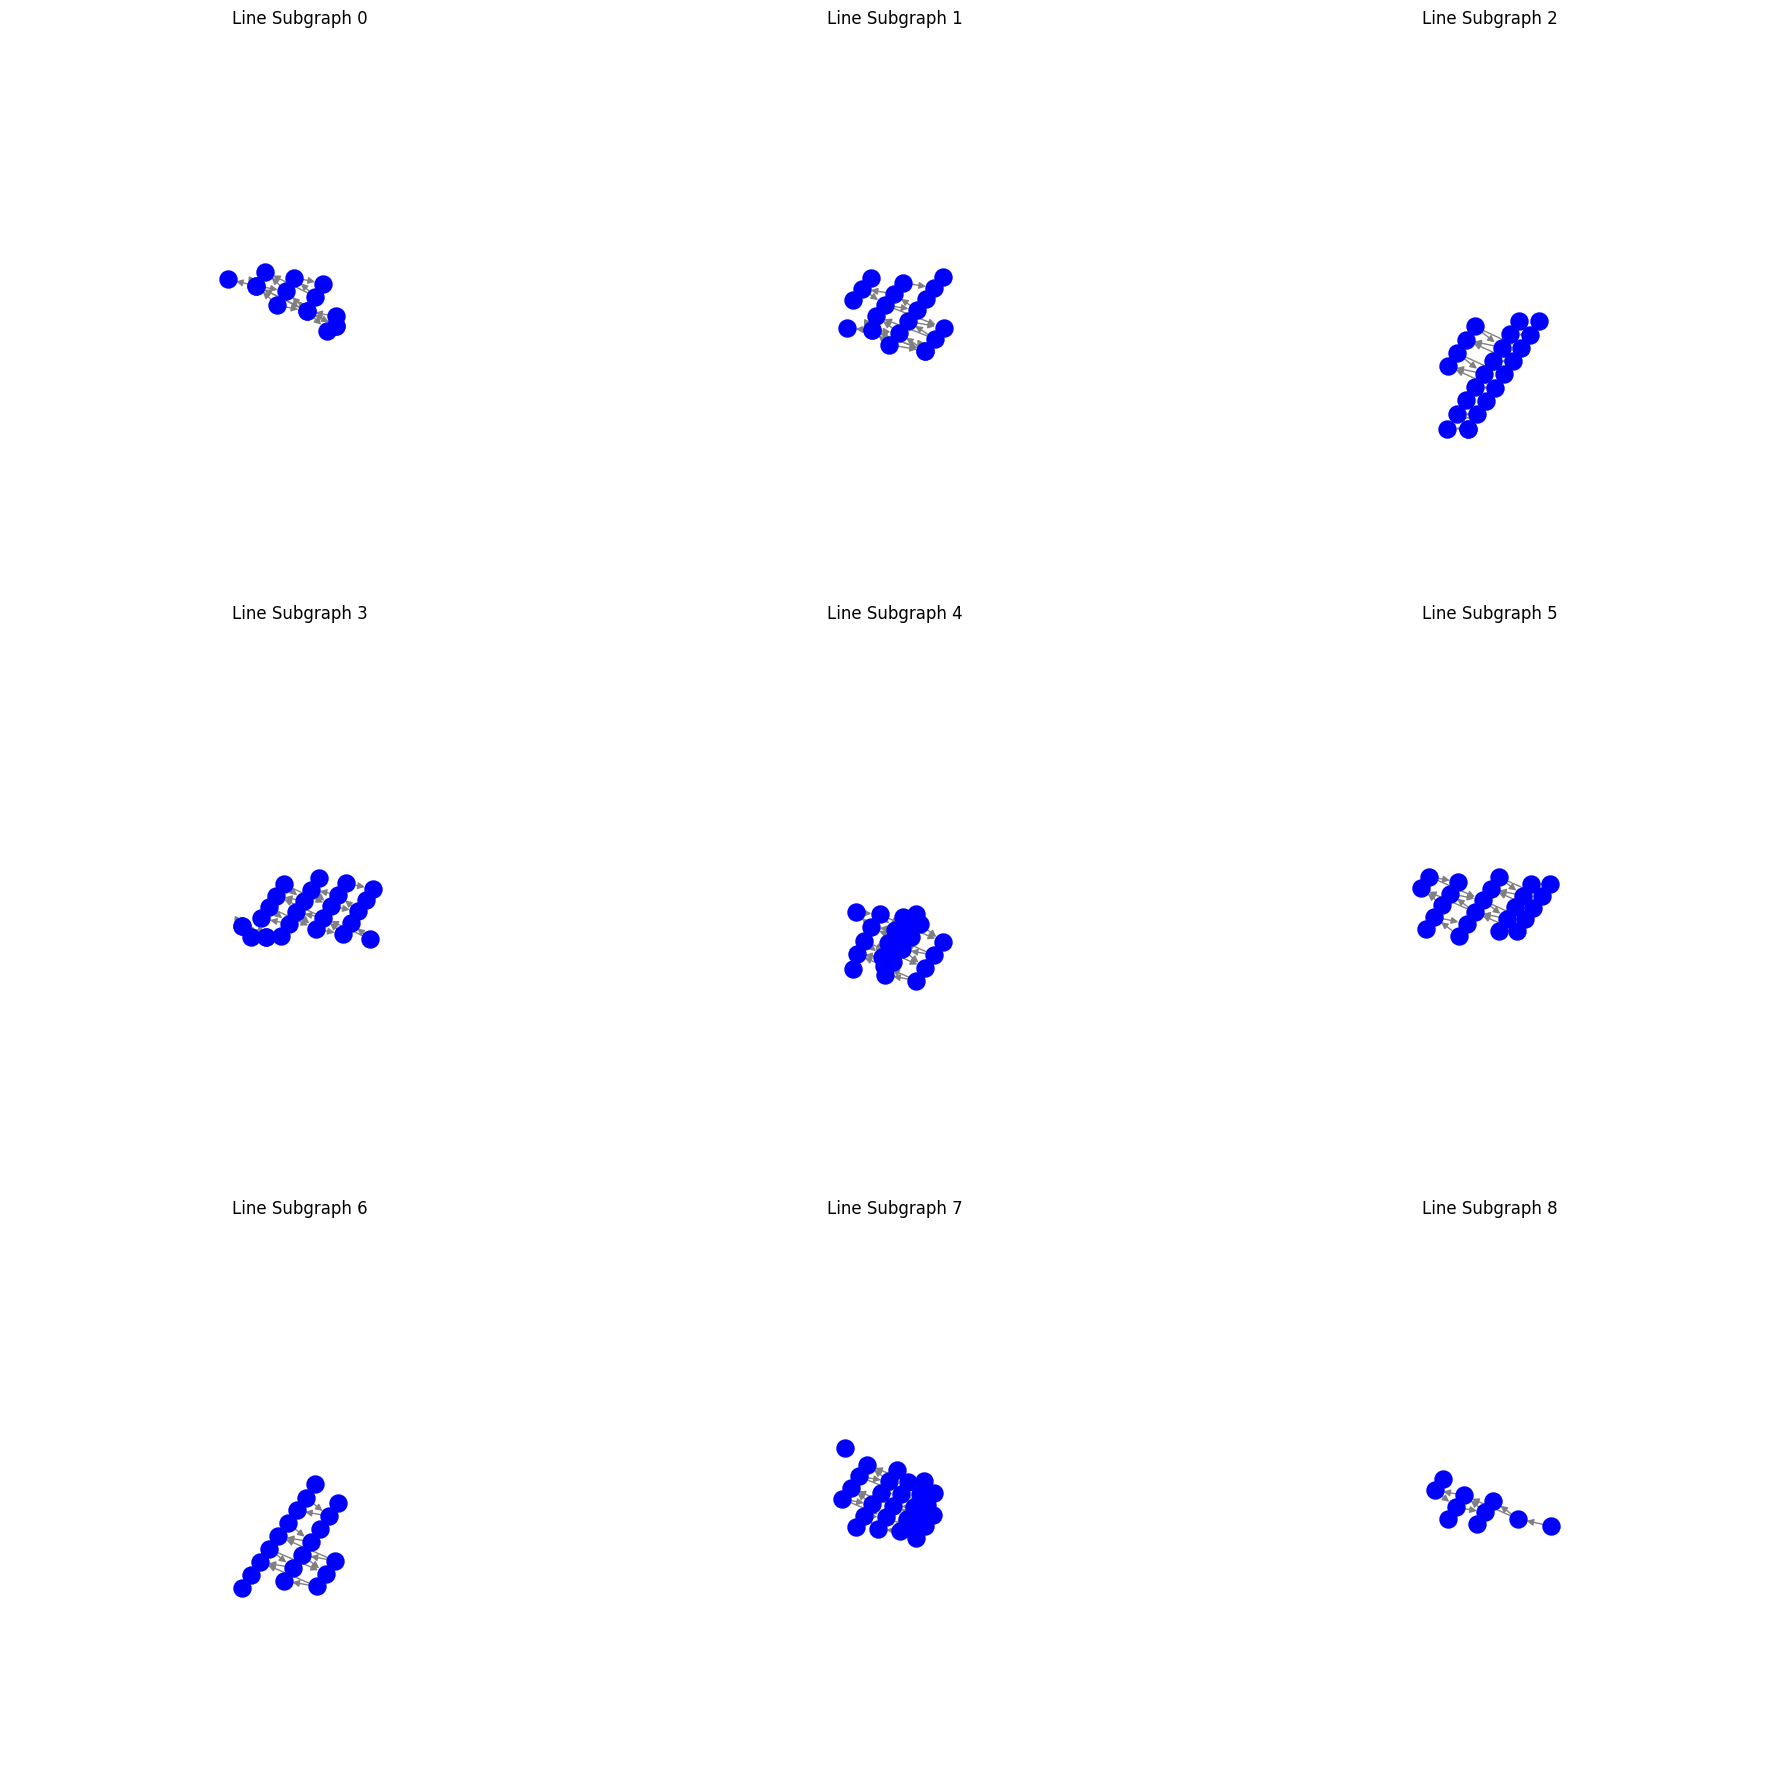

In [3]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# --- Load graphs ---
with open(r"C:\Users\km_ka\Desktop\Demo\Dataset\Meta_Data\line_graph.pkl", "rb") as f:
    L = pickle.load(f)

with open(r"C:\Users\km_ka\Desktop\Demo\Dataset\Meta_Data\G_custom.pkl", "rb") as f:
    G_custom = pickle.load(f)

# --- Create a mapping for line graph nodes (optional) ---
line_graph_id_map = {(u, v): f"{u}_{v}" for (u, v) in L.nodes()}

# --- Get x/y coordinates of nodes in G_custom ---
xs = [G_custom.nodes[n]['x'] for n in G_custom.nodes()]
ys = [G_custom.nodes[n]['y'] for n in G_custom.nodes()]

# --- Calculate thresholds to divide into 3x3 regions ---
x1, x2 = np.percentile(xs, [33.33, 66.67])
y1, y2 = np.percentile(ys, [33.33, 66.67])

# --- Assign line graph nodes to regions ---
regions_line = {i: [] for i in range(9)}

for node in L.nodes():
    u, v = node
    x_mid = (G_custom.nodes[u]['x'] + G_custom.nodes[v]['x']) / 2
    y_mid = (G_custom.nodes[u]['y'] + G_custom.nodes[v]['y']) / 2

    if x_mid < x1:        # Left
        if y_mid < y1:    # Bottom
            regions_line[0].append(node)
        elif y_mid < y2:  # Middle
            regions_line[3].append(node)
        else:             # Top
            regions_line[6].append(node)
    elif x_mid < x2:      # Center
        if y_mid < y1:
            regions_line[1].append(node)
        elif y_mid < y2:
            regions_line[4].append(node)
        else:
            regions_line[7].append(node)
    else:                 # Right
        if y_mid < y1:
            regions_line[2].append(node)
        elif y_mid < y2:
            regions_line[5].append(node)
        else:
            regions_line[8].append(node)

# --- Create subgraphs ---
line_subgraphs = [L.subgraph(regions_line[r]).copy() for r in range(9)]

# --- Plot subgraphs ---
fig, axes = plt.subplots(3, 3, figsize=(18, 18))  # bigger figure
axes = axes.flatten()

for i, subL in enumerate(line_subgraphs):
    # Compute positions as midpoints of connected nodes
    pos = {}
    for (u, v) in subL.nodes():
        x1_coord, y1_coord = G_custom.nodes[u]['x'], G_custom.nodes[u]['y']
        x2_coord, y2_coord = G_custom.nodes[v]['x'], G_custom.nodes[v]['y']
        pos[(u, v)] = ((x1_coord + x2_coord) / 2, (y1_coord + y2_coord) / 2)

    nx.draw(subL, pos=pos, ax=axes[i],
            node_size=150,       # larger nodes
            font_size=10,        # larger labels
            with_labels=False,
            edge_color='gray',
            arrows=True,
            node_color='blue')

    axes[i].set_title(f"Line Subgraph {i}", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [46]:
import os
import torch

checkpoint_dir = r"C:\Users\km_ka\Desktop\Demo\Checkpoints\fedcls_check"

# List all .pt files in the directory
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pt")])

all_masks = {}

for ckpt_file in checkpoint_files:
    ckpt_path = os.path.join(checkpoint_dir, ckpt_file)
    checkpoint = torch.load(ckpt_path, map_location="cpu")  # load on CPU

    mask = checkpoint["mask"]
    round_num = checkpoint.get("round", None)
    client_id = int(ckpt_file.split("_")[1])
    if client_id not in all_masks:
        all_masks[client_id] = {}
    all_masks[client_id][round_num] = mask

    print(f"Loaded mask for Client {client_id}, Round {round_num}, shape: {mask.shape}")
    


Loaded mask for Client 0, Round 10, shape: torch.Size([15])
Loaded mask for Client 1, Round 10, shape: torch.Size([21])
Loaded mask for Client 2, Round 10, shape: torch.Size([23])
Loaded mask for Client 3, Round 10, shape: torch.Size([26])
Loaded mask for Client 4, Round 10, shape: torch.Size([24])
Loaded mask for Client 5, Round 10, shape: torch.Size([23])
Loaded mask for Client 6, Round 10, shape: torch.Size([19])
Loaded mask for Client 7, Round 10, shape: torch.Size([28])
Loaded mask for Client 8, Round 10, shape: torch.Size([10])


In [47]:
import numpy as np

# Example: combine first round of each client with the subgraph
subgraphs_with_masks = []

for client_id, rounds in all_masks.items():
    # Choose a specific round, e.g., the latest round
    latest_round = max(rounds.keys())
    mask = rounds[latest_round].numpy() if torch.is_tensor(rounds[latest_round]) else rounds[latest_round]

    # Compute missing indexes from mask
    missing_indexes = np.where(mask == 0)[0]

    # Get the corresponding subgraph (assuming client_id indexes subgraphs_loaded)
    # Adjust this indexing if client_id does not match subgraph index
    Xq, Aq = subgraphs_test_loaded[client_id]

    # Combine into a tuple
    subgraphs_with_masks.append((Xq, Aq, mask, missing_indexes))

    print(f"Client {client_id}, Round {latest_round}: mask shape = {mask.shape}, missing nodes = {missing_indexes}")


Client 0, Round 10: mask shape = (15,), missing nodes = [1 8]
Client 1, Round 10: mask shape = (21,), missing nodes = [ 1  2 18]
Client 2, Round 10: mask shape = (23,), missing nodes = [ 7 12 22]
Client 3, Round 10: mask shape = (26,), missing nodes = [ 3 13 16 23]
Client 4, Round 10: mask shape = (24,), missing nodes = [ 1  2 16 22]
Client 5, Round 10: mask shape = (23,), missing nodes = [ 5 17 19]
Client 6, Round 10: mask shape = (19,), missing nodes = [ 3 11 14]
Client 7, Round 10: mask shape = (28,), missing nodes = [ 4  8 16 22]
Client 8, Round 10: mask shape = (10,), missing nodes = [2 4]


In [48]:
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
all_loaders = fed_utils.build_dataloaders(
    subgraphs_with_masks=subgraphs_with_masks,
    create_sequences=fed_utils.create_sequences,  # your function
    device=device
)
print(f"✅ Total number of DataLoaders created: {len(all_loaders)}")

✔ Subgraph 0: 364 sequences, 23 batches
✔ Subgraph 1: 364 sequences, 23 batches
✔ Subgraph 2: 364 sequences, 23 batches
✔ Subgraph 3: 364 sequences, 23 batches
✔ Subgraph 4: 364 sequences, 23 batches
✔ Subgraph 5: 364 sequences, 23 batches
✔ Subgraph 6: 364 sequences, 23 batches
✔ Subgraph 7: 364 sequences, 23 batches
✔ Subgraph 8: 364 sequences, 23 batches
✅ Total number of DataLoaders created: 9


In [49]:
import os
import torch

checkpoint_dir = r"C:\Users\km_ka\Desktop\Demo\Checkpoints\fedcls_check"

# List all checkpoint files
checkpoint_files = sorted([f for f in os.listdir(checkpoint_dir) if f.endswith(".pt")])

all_client_models = {}

for ckpt_file in checkpoint_files:
    ckpt_path = os.path.join(checkpoint_dir, ckpt_file)
    checkpoint = torch.load(ckpt_path, map_location="cpu")

    model_state_dict = checkpoint["model_state_dict"]
    round_num = checkpoint.get("round", None)
    client_id = int(ckpt_file.split("_")[1])

    # --- instantiate the model (must match training architecture) ---
    model = fed_utils.FedRepModel(
        in_features=6,        # replace with actual input feature dim
        hidden_dim=16,
        forecast_len=6,        # replace with actual prediction length
        sequence_len=8,        # replace with actual sequence length
        num_nodes=15,          # replace with actual number of nodes
        projection_dim=32,
        k_hop=2,
    )

    # --- load trained weights ---
    model.load_state_dict(model_state_dict)

    # --- store model ---
    if client_id not in all_client_models:
        all_client_models[client_id] = {}
    all_client_models[client_id][round_num] = model

    print(f"✅ Loaded model for Client {client_id}, Round {round_num}")

# Example: access model for client 0, round 2
# client0_round2_model = all_client_models[0][2]


✅ Loaded model for Client 0, Round 10
✅ Loaded model for Client 1, Round 10
✅ Loaded model for Client 2, Round 10
✅ Loaded model for Client 3, Round 10
✅ Loaded model for Client 4, Round 10
✅ Loaded model for Client 5, Round 10
✅ Loaded model for Client 6, Round 10
✅ Loaded model for Client 7, Round 10
✅ Loaded model for Client 8, Round 10


In [50]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Flattened weights for each client (pick a specific round if needed)
round_to_use = 10  # or choose the latest round available
weights_list = []

client_ids = sorted(all_client_models.keys())  # sorted client IDs

for cid in client_ids:
    model_dict = all_client_models[cid]
    # pick the weights of the specified round
    if round_to_use in model_dict:
        model = model_dict[round_to_use]
    else:
        # fallback: pick the latest round
        latest_round = max(model_dict.keys())
        model = model_dict[latest_round]

    # Flatten all parameters into a 1D array
    params = np.concatenate([p.detach().cpu().numpy().flatten() for p in model.parameters()])
    weights_list.append(params)

weights_matrix = np.array(weights_list)  # shape [n_clients, total_params]
print("Weights matrix shape:", weights_matrix.shape)


Weights matrix shape: (9, 27704)


In [11]:
tsne = TSNE(n_components=3, init='random', random_state=42, learning_rate='auto', perplexity=3)
projected = tsne.fit_transform(weights_matrix)  # [n_clients, 3]


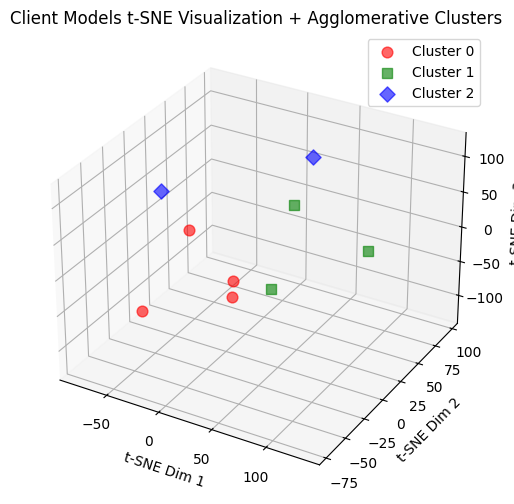

In [ ]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# weights_matrix: shape [n_clients, total_params]

# 1️⃣ Cluster in the original weight space
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_labels = kmeans.fit_predict(weights_matrix)

# 2️⃣ t-SNE for visualization
tsne = TSNE(n_components=3, init='random', random_state=42, learning_rate='auto', perplexity=3)
projected = tsne.fit_transform(weights_matrix)

# 3️⃣ 3D scatter plot with cluster colors
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

colors = ['r','g','b']
markers = ['o','s','D']

for i in range(len(projected)):
    cluster_idx = cluster_labels[i]
    ax.scatter(
        projected[i,0], projected[i,1], projected[i,2],
        s=60,
        color=colors[cluster_idx],
        marker=markers[cluster_idx],
        alpha=0.6,
        label=f"Cluster {cluster_idx}"
    )

# Fix legend
handles, labels = ax.get_legend_handles_labels()
unique = dict(zip(labels, handles))
ax.legend(unique.values(), unique.keys())

ax.set_title("Client Models t-SNE Visualization + Correct Clusters")
ax.set_xlabel("t-SNE Dim 1")
ax.set_ylabel("t-SNE Dim 2")
ax.set_zlabel("t-SNE Dim 3")
plt.show()


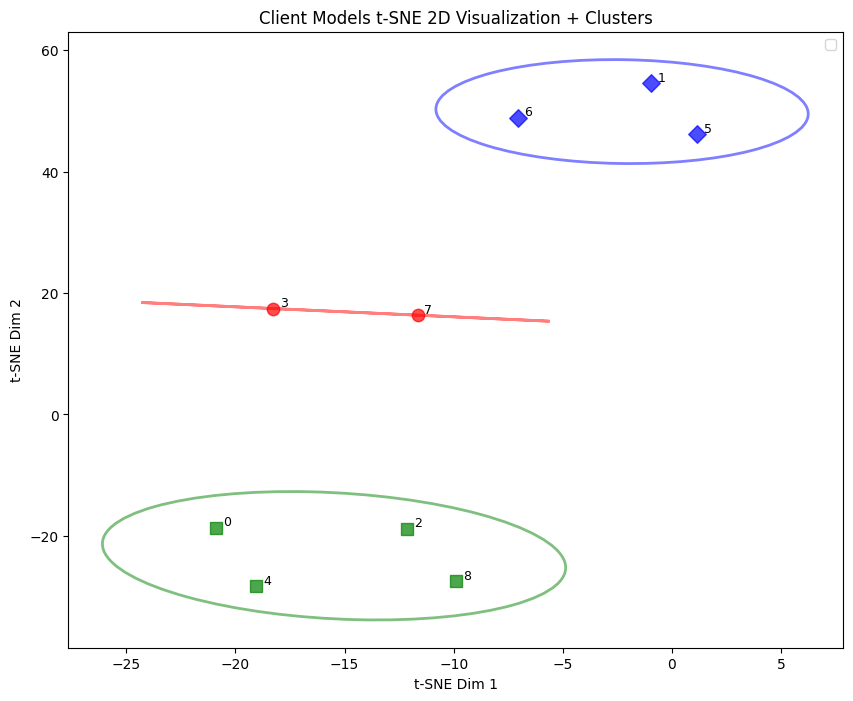

In [20]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Ellipse

# weights_matrix: shape [n_clients, total_params]
client_ids = list(range(weights_matrix.shape[0]))  # replace with your actual client IDs if needed

# 1️⃣ Cluster in the original weight space
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(weights_matrix)

# 2️⃣ t-SNE for 2D visualization
tsne = TSNE(n_components=2, init='random', random_state=42, learning_rate='auto', perplexity=3)
projected = tsne.fit_transform(weights_matrix)  # shape [n_clients, 2]

# 3️⃣ 2D scatter plot with cluster colors
plt.figure(figsize=(10,8))
colors = ['r','g','b']
markers = ['o','s','D']

for i in range(len(projected)):
    cluster_idx = cluster_labels[i]
    plt.scatter(
        projected[i,0], projected[i,1],
        s=80,
        color=colors[cluster_idx],
        marker=markers[cluster_idx],
        alpha=0.7
    )
    # Add client ID label slightly offset from the point
    plt.text(
        projected[i,0]+0.3, projected[i,1]+0.3,
        str(client_ids[i]),
        fontsize=9,
        color='black'
    )

# 4️⃣ Draw ellipses/circles around each cluster
for cluster_idx in range(n_clusters):
    cluster_points = projected[cluster_labels == cluster_idx]
    if len(cluster_points) == 0:
        continue
    # Compute mean and covariance
    mean = cluster_points.mean(axis=0)
    cov = np.cov(cluster_points, rowvar=False)
    # Eigenvalues/eigenvectors for ellipse size and orientation
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
    width, height = 2 * np.sqrt(vals) * 2  # factor 2 for visual padding
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=theta, edgecolor=colors[cluster_idx],
                      facecolor='none', lw=2, alpha=0.5)
    plt.gca().add_patch(ellipse)

# Fix legend
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
plt.legend(unique.values(), unique.keys())

plt.title("Client Models t-SNE 2D Visualization + Clusters")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()


Inference for getting forecasting results 

In [52]:
import torch
import numpy as np
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
loss_fn = torch.nn.MSELoss(reduction='none')  # per-element imputation loss
all_clients_results = {}

# ---------------- LOOP OVER CLIENTS ----------------
for client_id, rounds_dict in all_client_models.items():
    print(f"\n--- Evaluating Client {client_id} ---")
    loader = all_loaders[client_id]
    
    features, adj_matrix_np, node_mask_np, missing_idxs = subgraphs_with_masks[client_id]
    adj_matrix = torch.tensor(adj_matrix_np, dtype=torch.float32, device=device)
    node_mask  = torch.tensor(node_mask_np, dtype=torch.float32, device=device)

    client_results = {}

    for round_num, model in rounds_dict.items():
        model.to(device)
        model.eval()
        all_preds, all_truepred, all_trueimpute, all_imputes = [], [], [], []

        with torch.no_grad():
            for xb, yb in loader:
                xb, yb = xb.to(device), yb.to(device)
                B, T, N, F = xb.shape

                # Expand node_mask to match batch and sequence dimensions
                mask = node_mask.unsqueeze(0).unsqueeze(1).unsqueeze(-1).expand(B, T, N, F)
                target = 1 - mask
                xb_noisy = xb * mask

                # Forward pass
                concat, fwd_out = model.encode(xb_noisy, adj_matrix, mask)
                impute = model.head_impute(concat)
                pred   = model.head_forecast(fwd_out)

                # Collect outputs
                all_preds.append(pred.cpu().numpy())
                all_truepred.append(yb.cpu().numpy())
                all_trueimpute.append(xb.cpu().numpy())
                all_imputes.append(impute.cpu().numpy())

        # Concatenate all batches
        all_preds = np.concatenate(all_preds, axis=0)
        all_truepred = np.concatenate(all_truepred, axis=0)
        all_trueimpute = np.concatenate(all_trueimpute, axis=0)
        all_imputes = np.concatenate(all_imputes, axis=0)

        client_results[round_num] = {
            "preds": all_preds,
            "true_pred": all_truepred,
            "true_impute": all_trueimpute,
            "imputes": all_imputes
        }

        print(f"✅ Client {client_id}, Round {round_num}: Collected {all_preds.shape[0]} samples")

    all_clients_results[client_id] = client_results

# ---------------- SAVE RESULTS ----------------
os.makedirs("evaluation_results", exist_ok=True)
np.savez("evaluation_results/all_clients_predictions.npz", all_clients_results)
print("✅ All client predictions saved to 'evaluation_results/all_clients_predictions.npz'")



--- Evaluating Client 0 ---
✅ Client 0, Round 10: Collected 364 samples

--- Evaluating Client 1 ---
✅ Client 1, Round 10: Collected 364 samples

--- Evaluating Client 2 ---
✅ Client 2, Round 10: Collected 364 samples

--- Evaluating Client 3 ---
✅ Client 3, Round 10: Collected 364 samples

--- Evaluating Client 4 ---
✅ Client 4, Round 10: Collected 364 samples

--- Evaluating Client 5 ---
✅ Client 5, Round 10: Collected 364 samples

--- Evaluating Client 6 ---
✅ Client 6, Round 10: Collected 364 samples

--- Evaluating Client 7 ---
✅ Client 7, Round 10: Collected 364 samples

--- Evaluating Client 8 ---
✅ Client 8, Round 10: Collected 364 samples
✅ All client predictions saved to 'evaluation_results/all_clients_predictions.npz'


In [53]:
import sys
import importlib
sys.path.append(r"C:\Users\km_ka\Desktop\Demo\utils")  
import vis_utils
importlib.reload(vis_utils) 

<module 'vis_utils' from 'C:\\Users\\km_ka\\Desktop\\Demo\\utils\\vis_utils.py'>

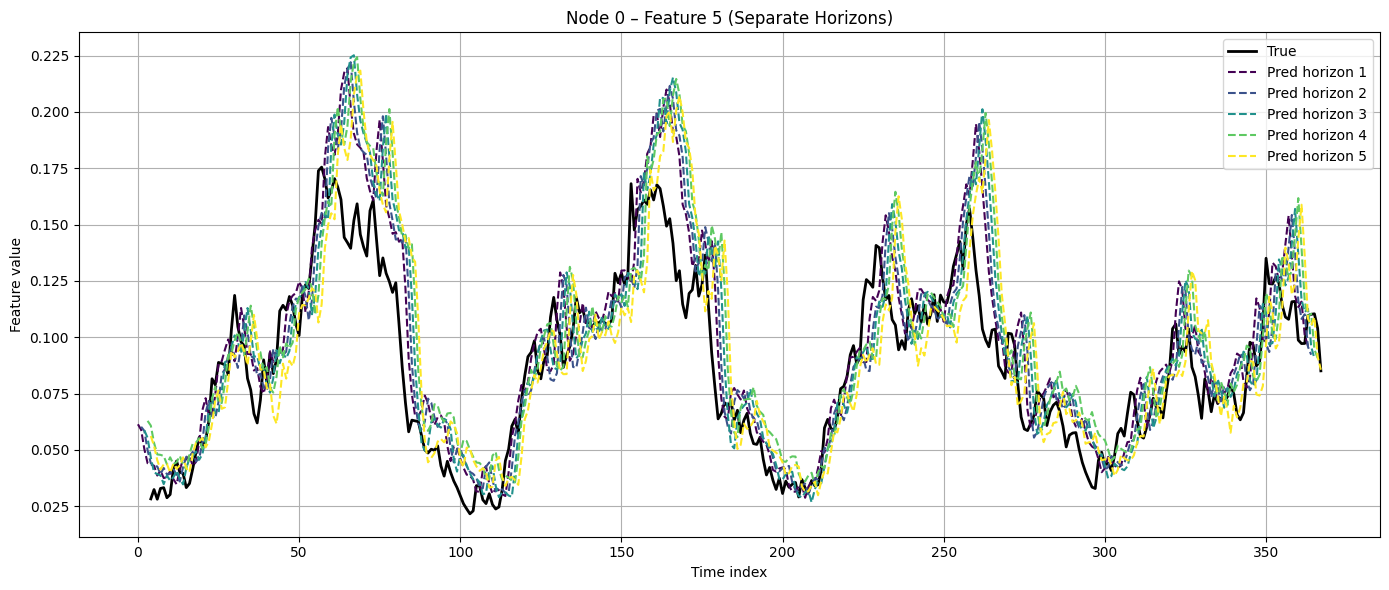

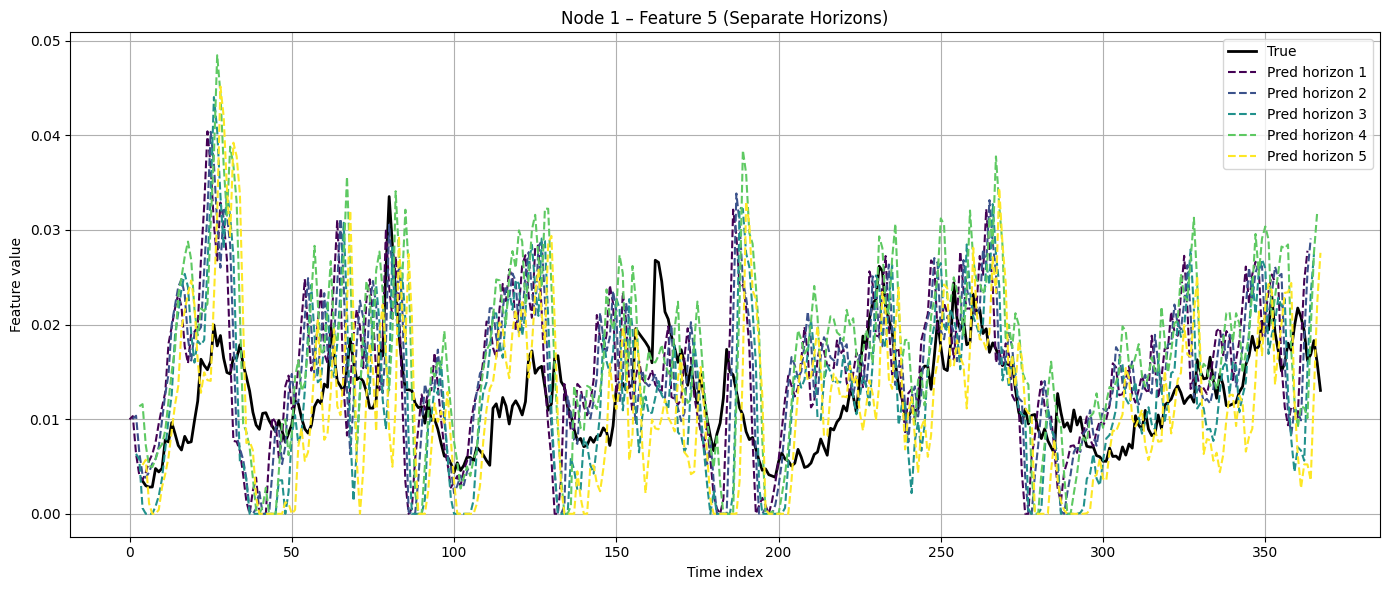

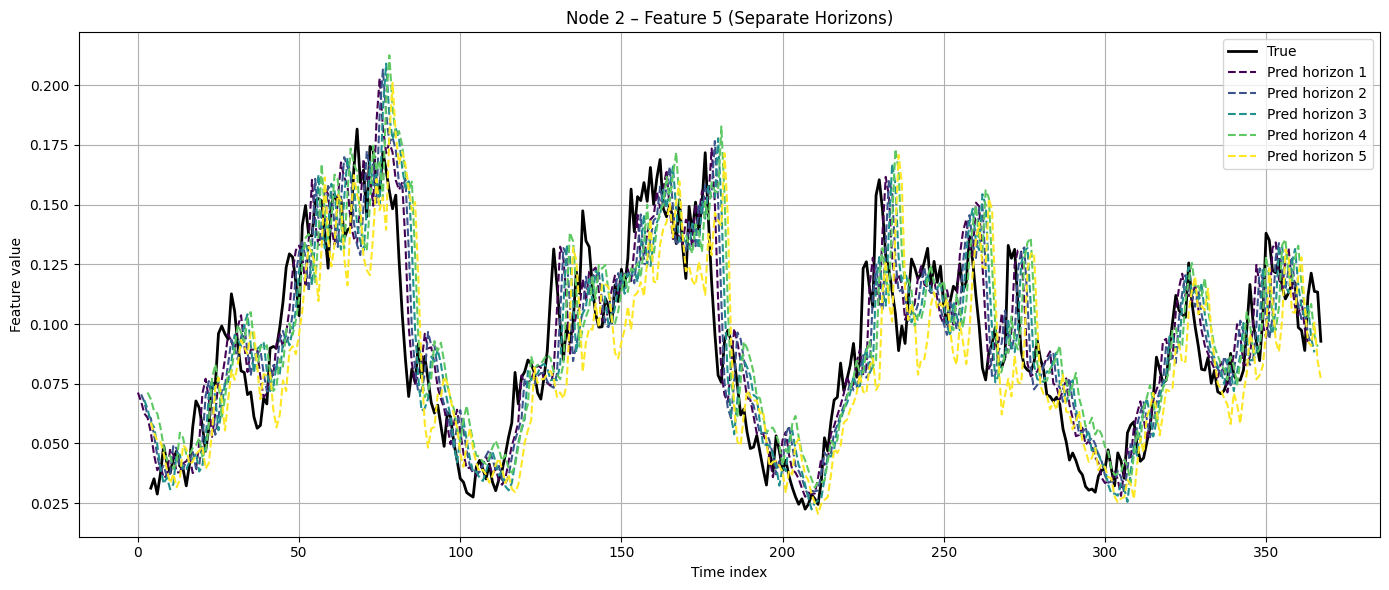

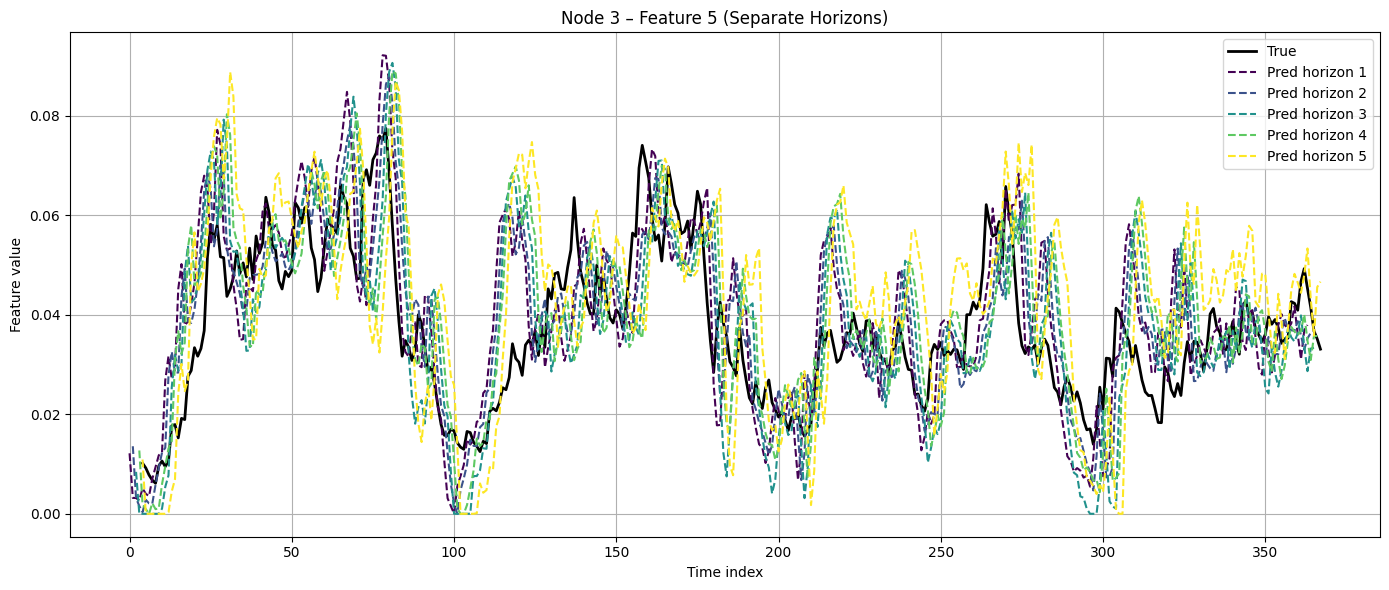

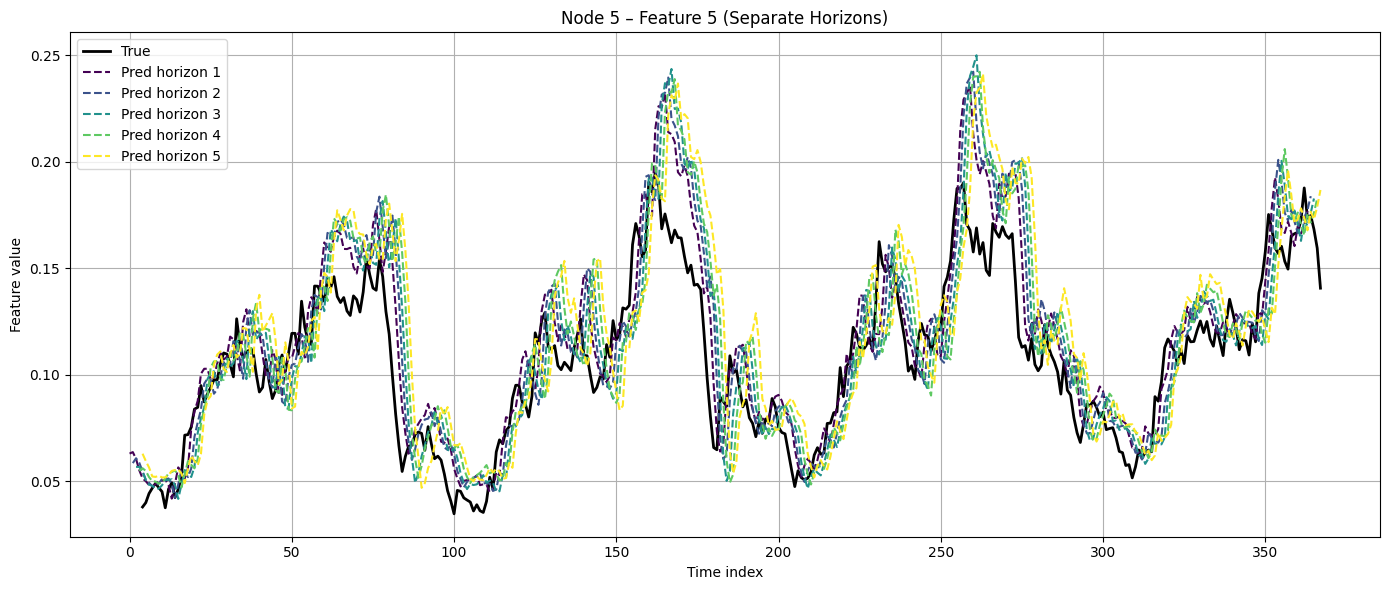

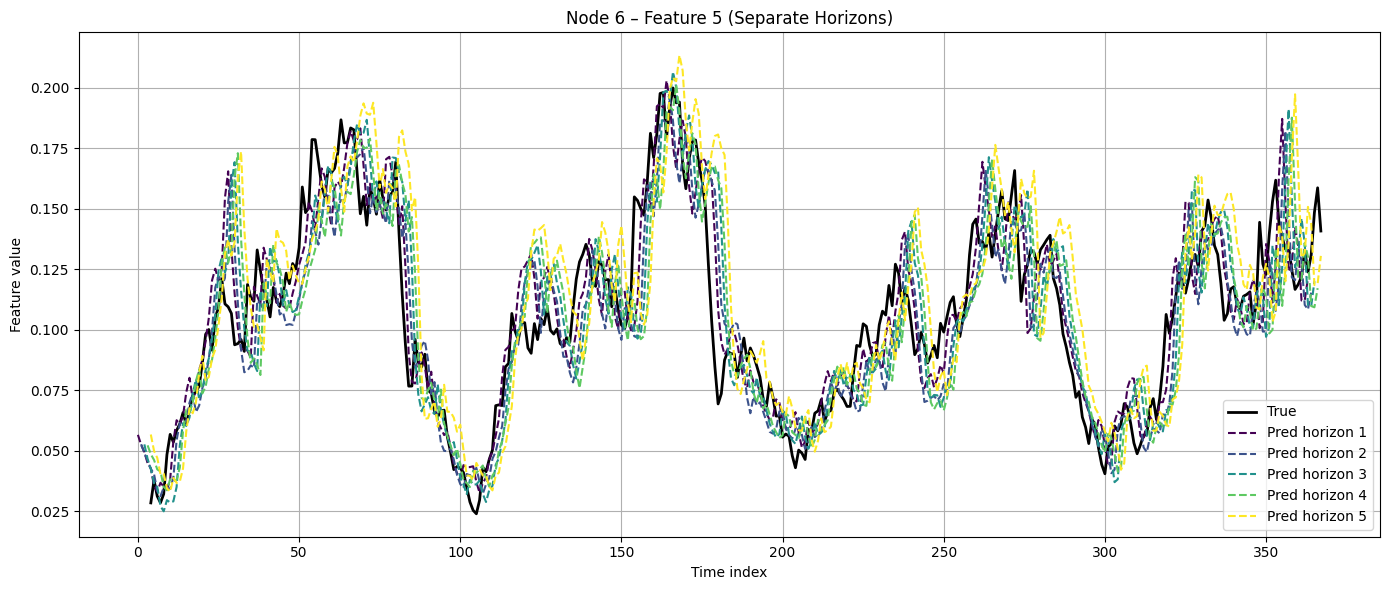

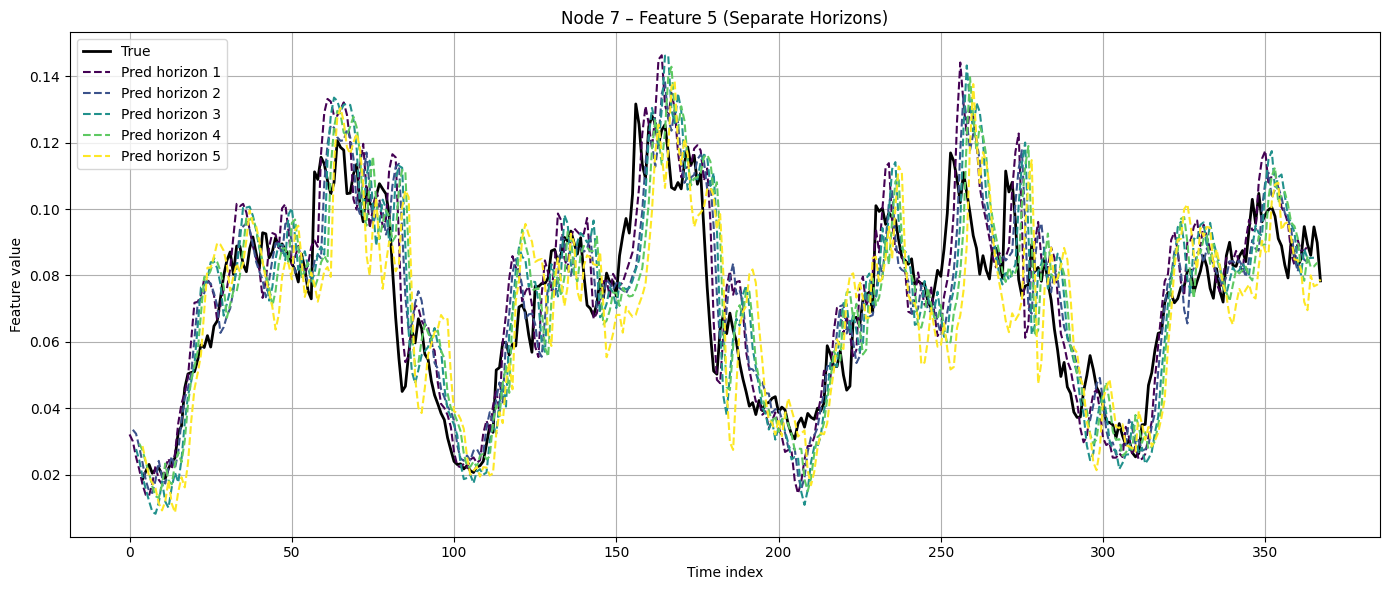

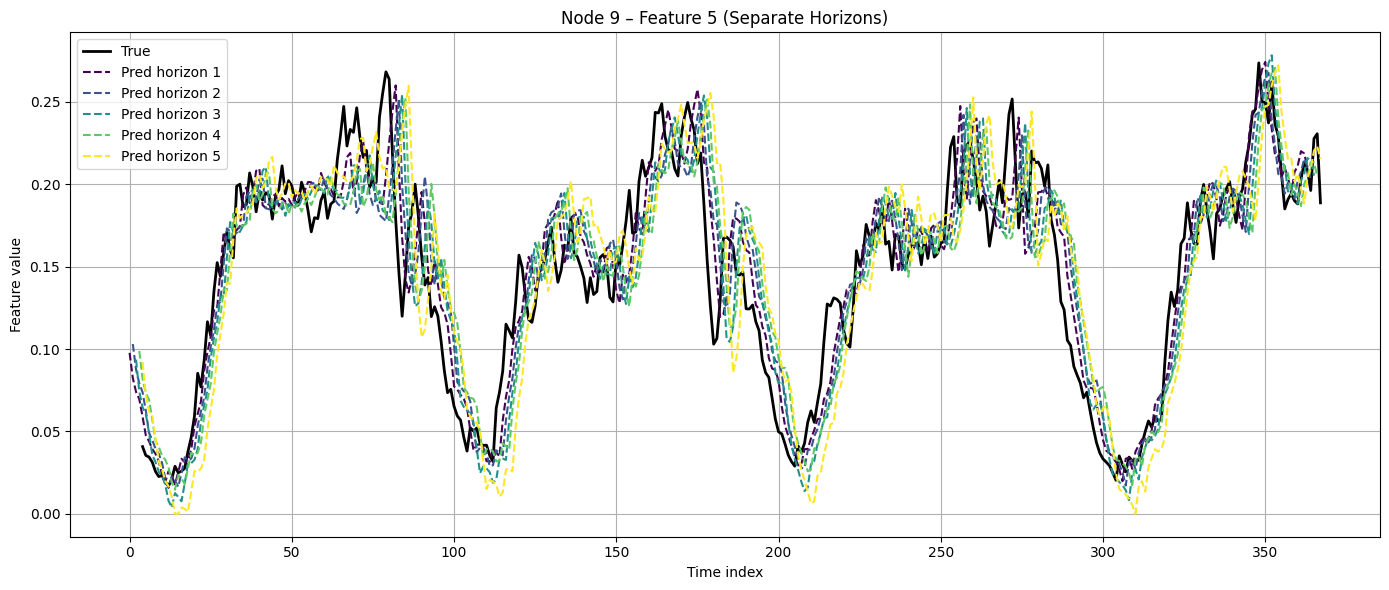

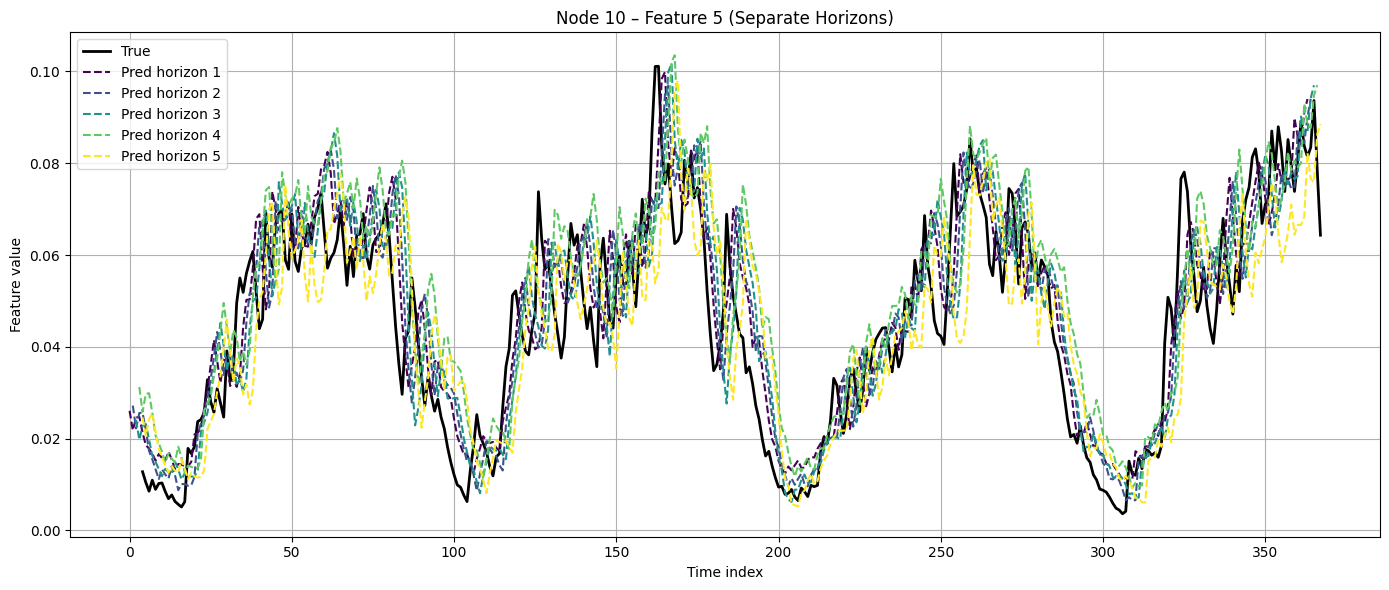

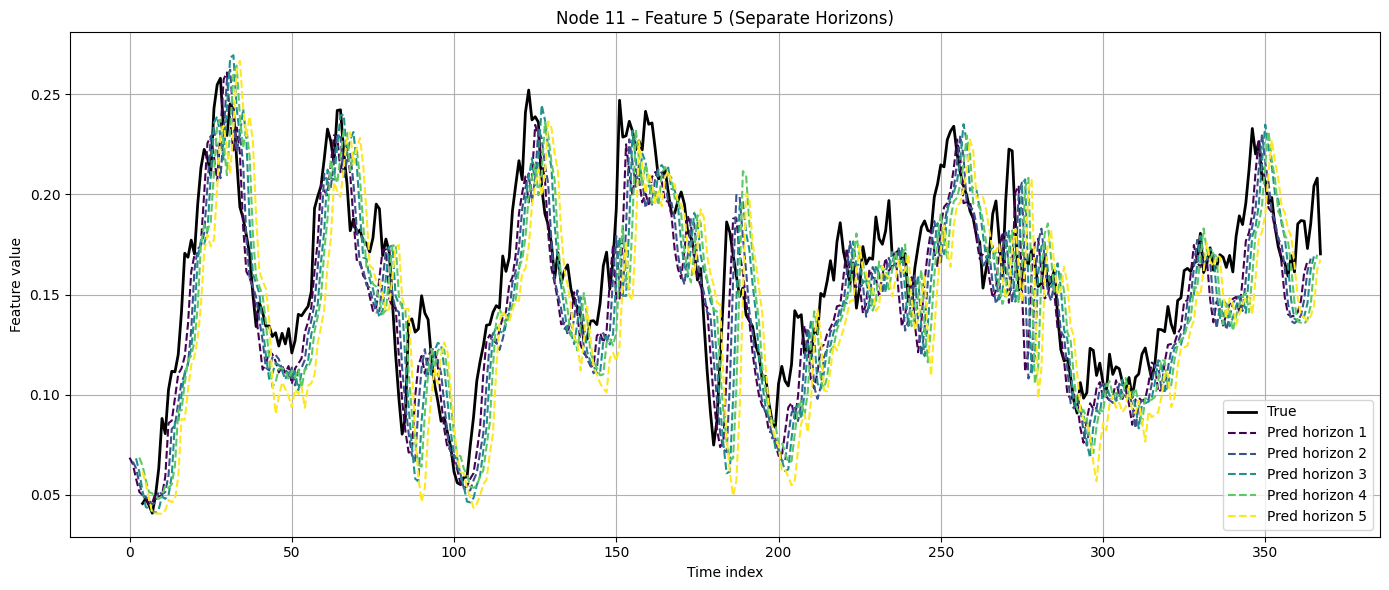

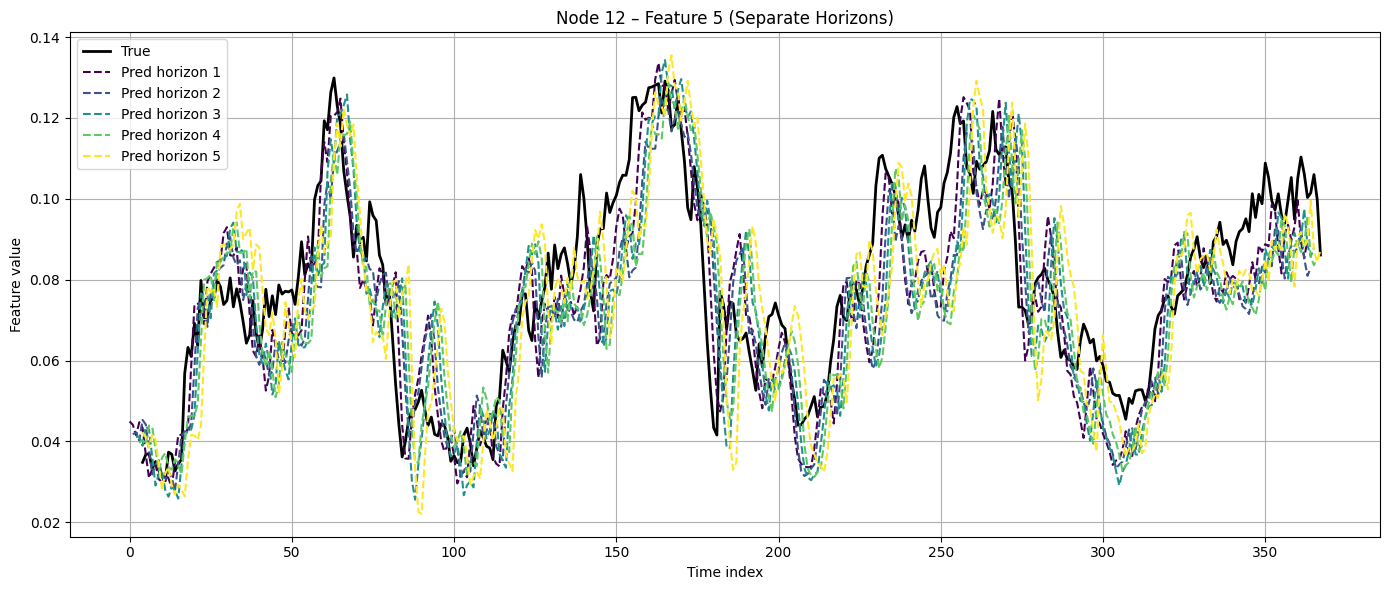

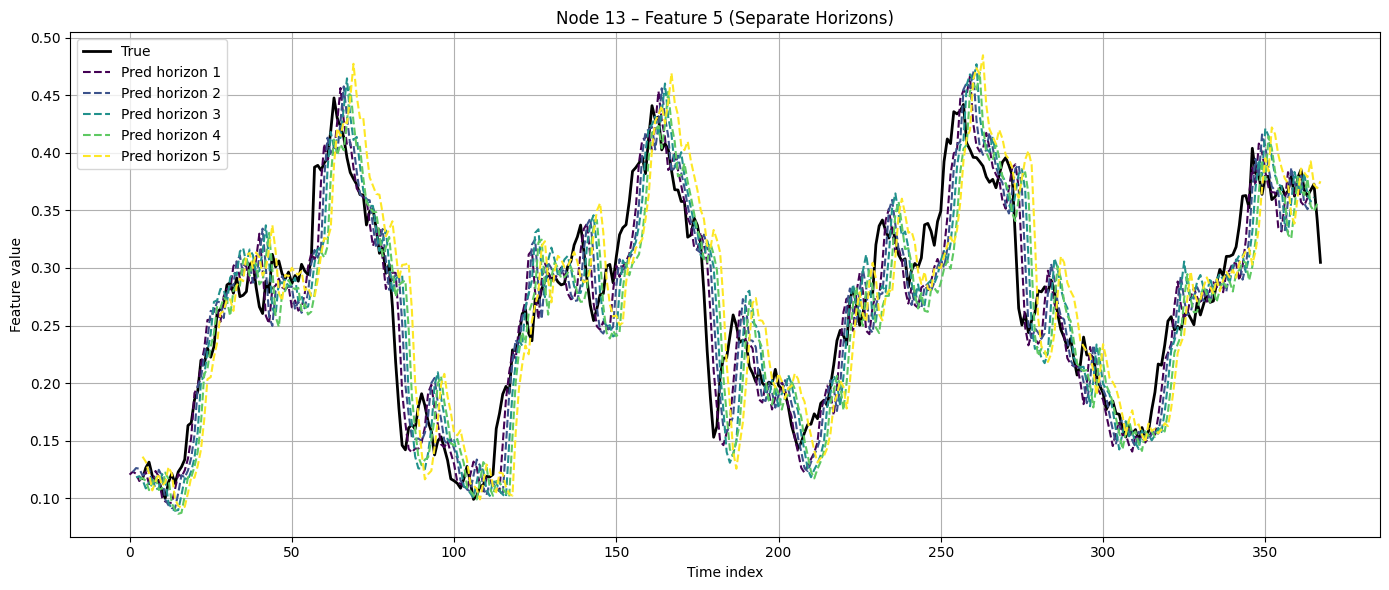

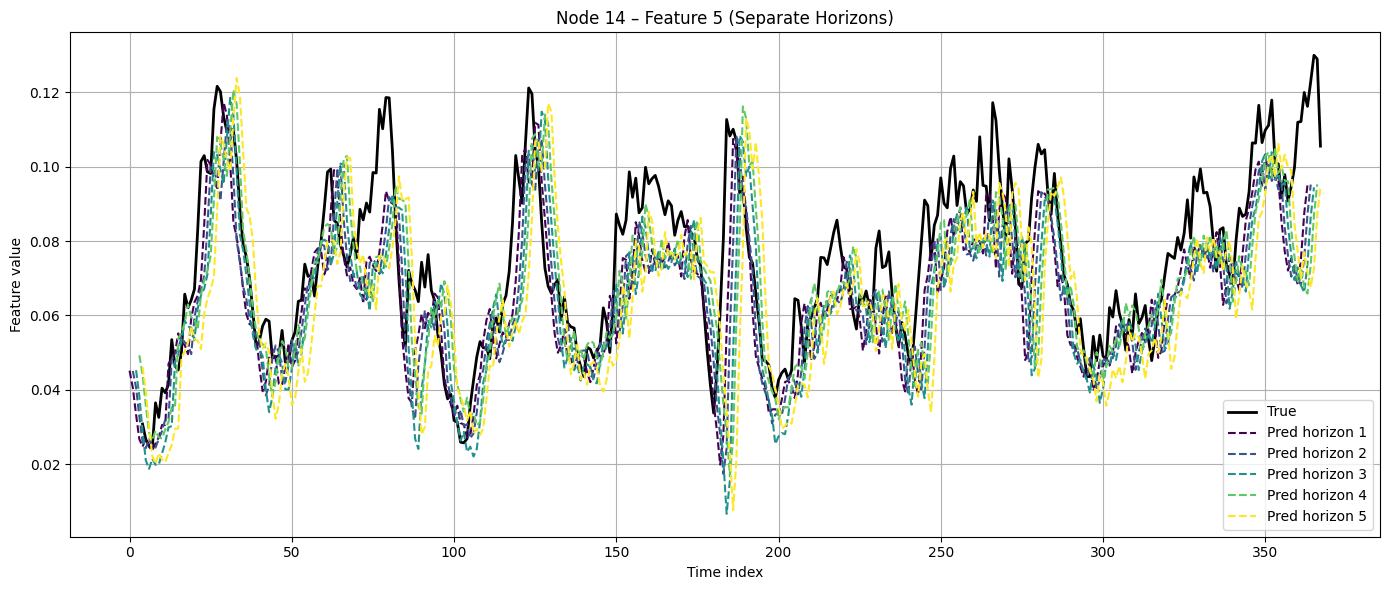

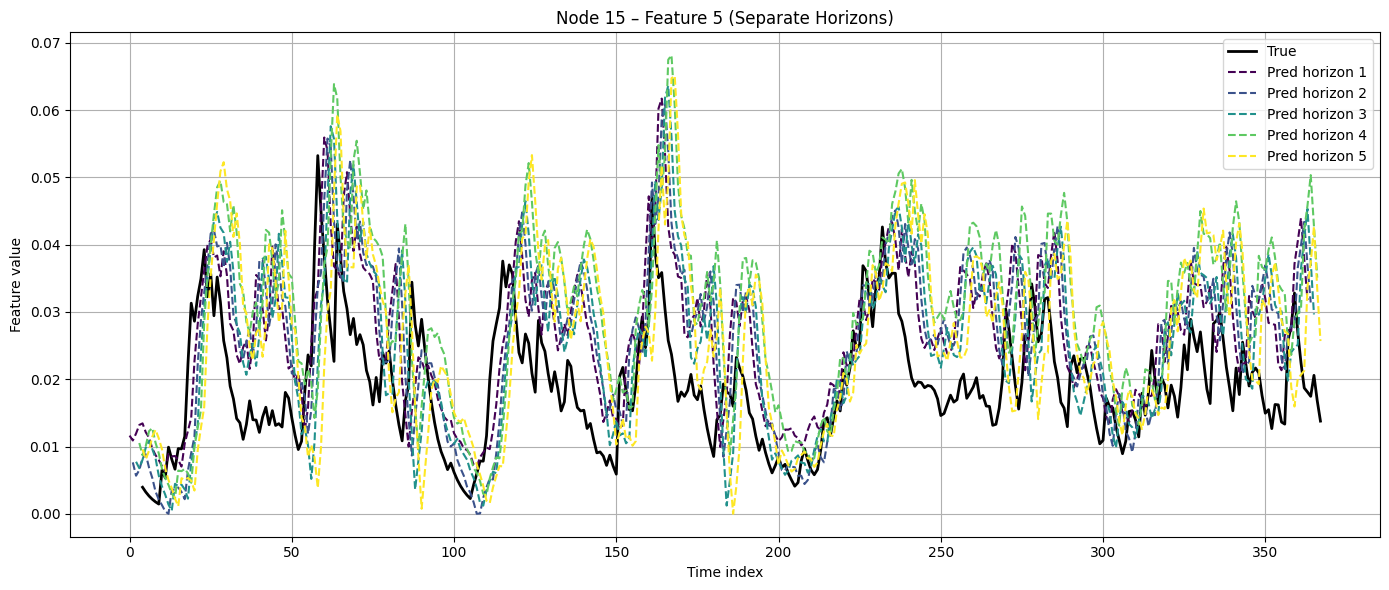

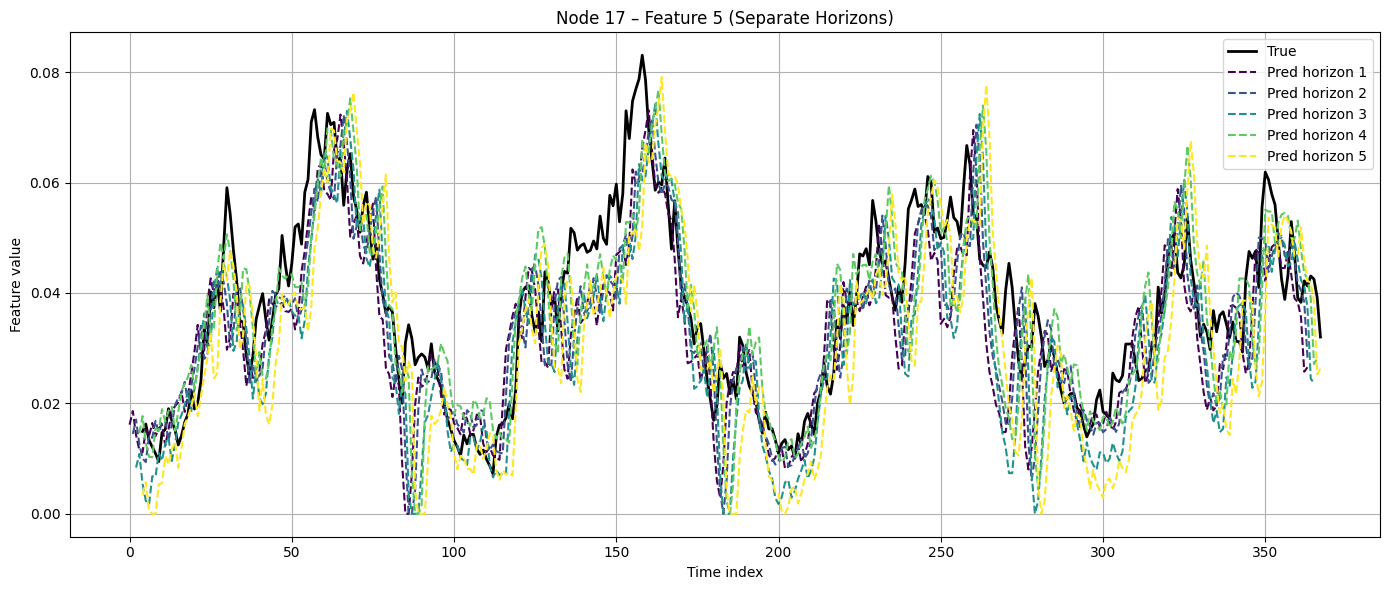

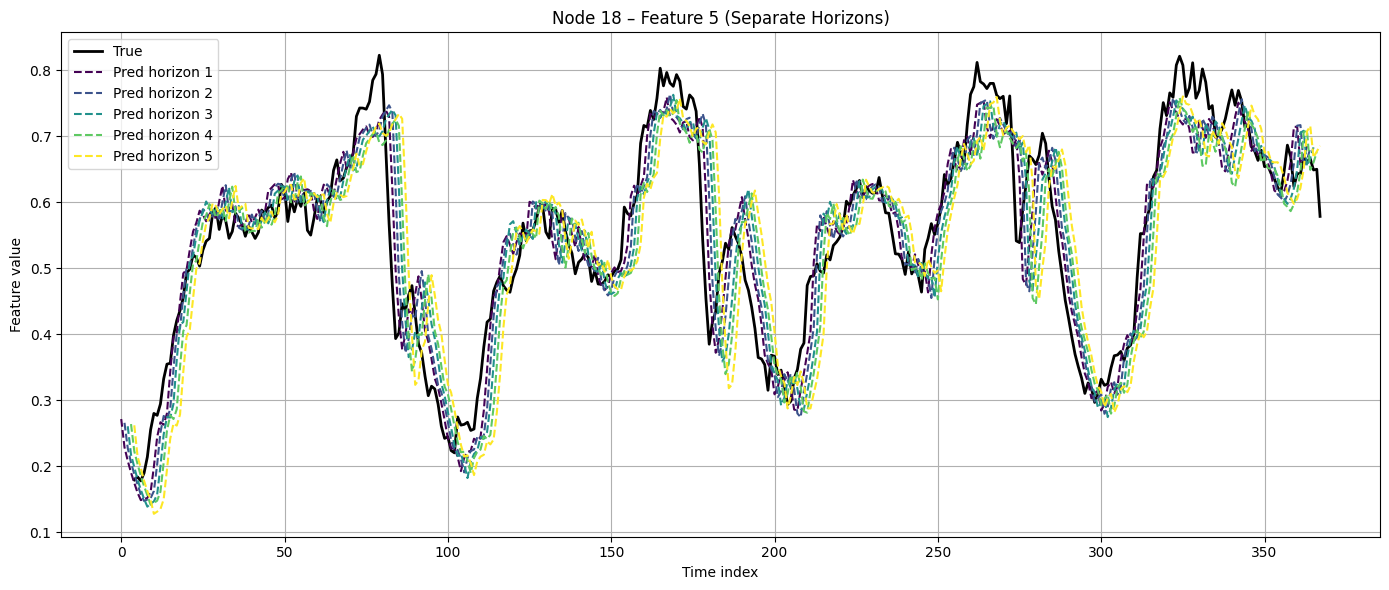

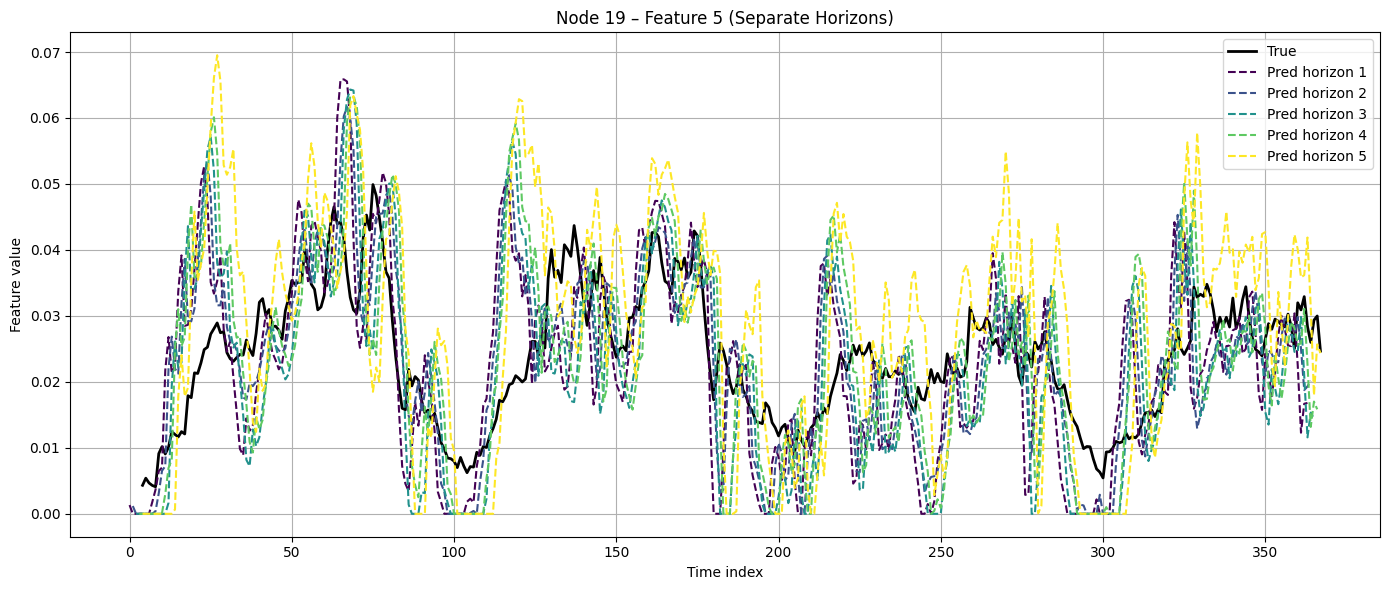

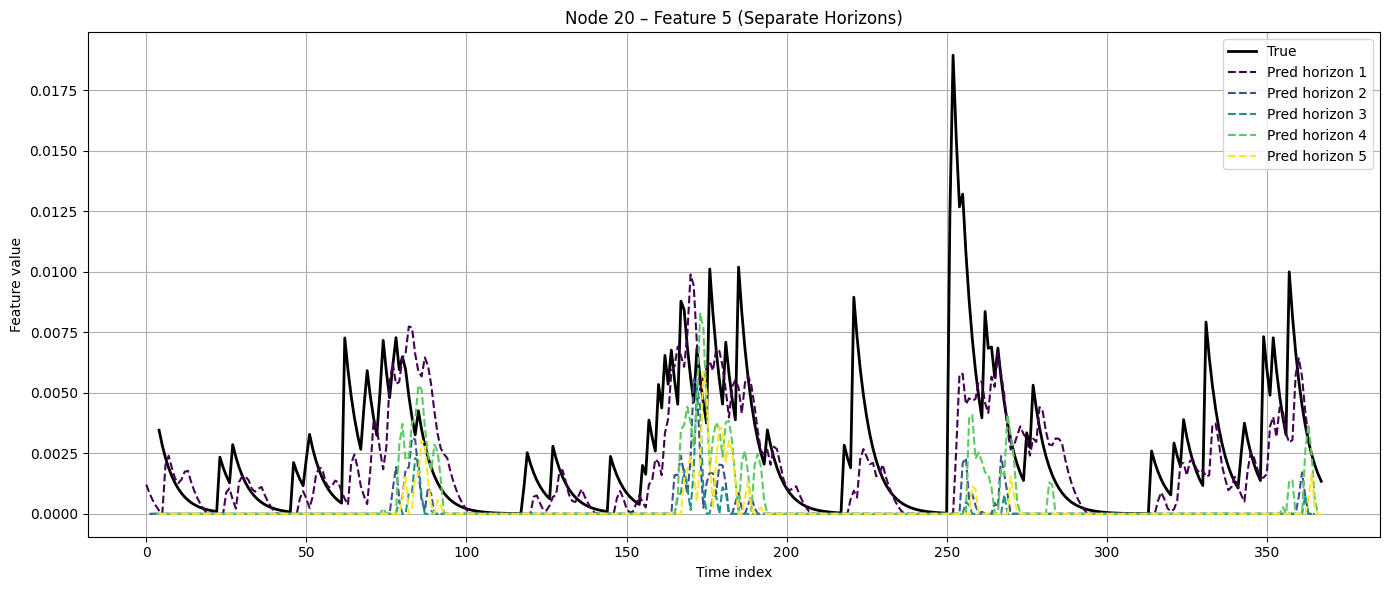

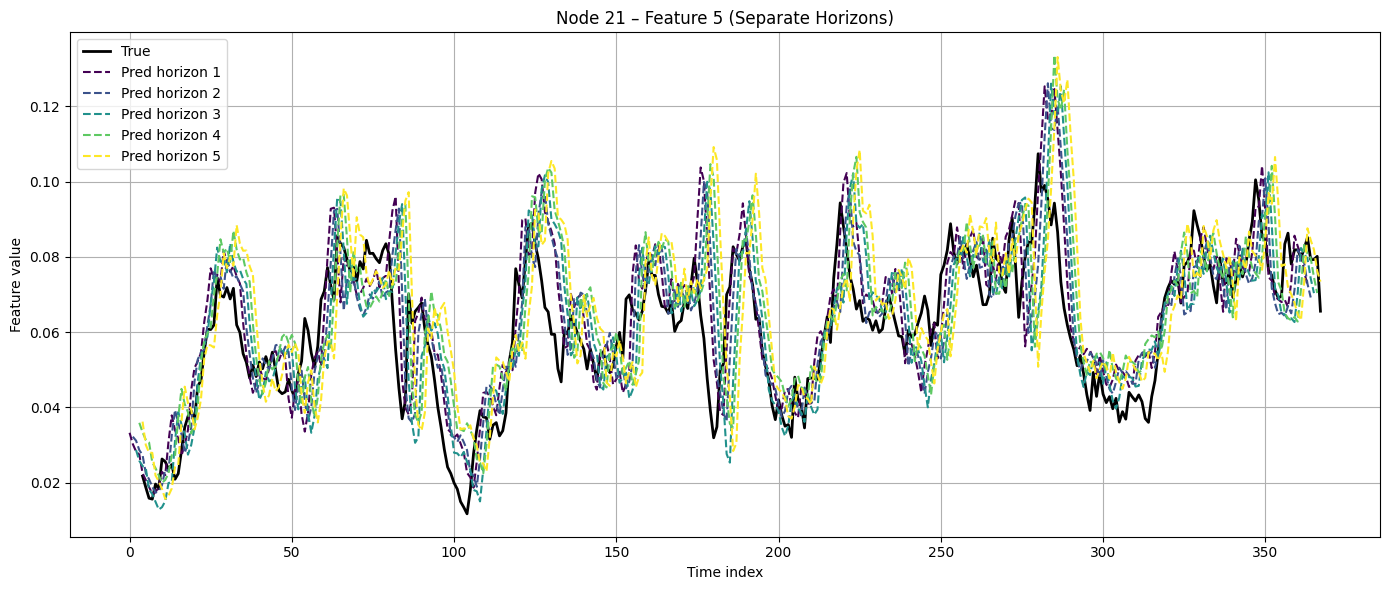

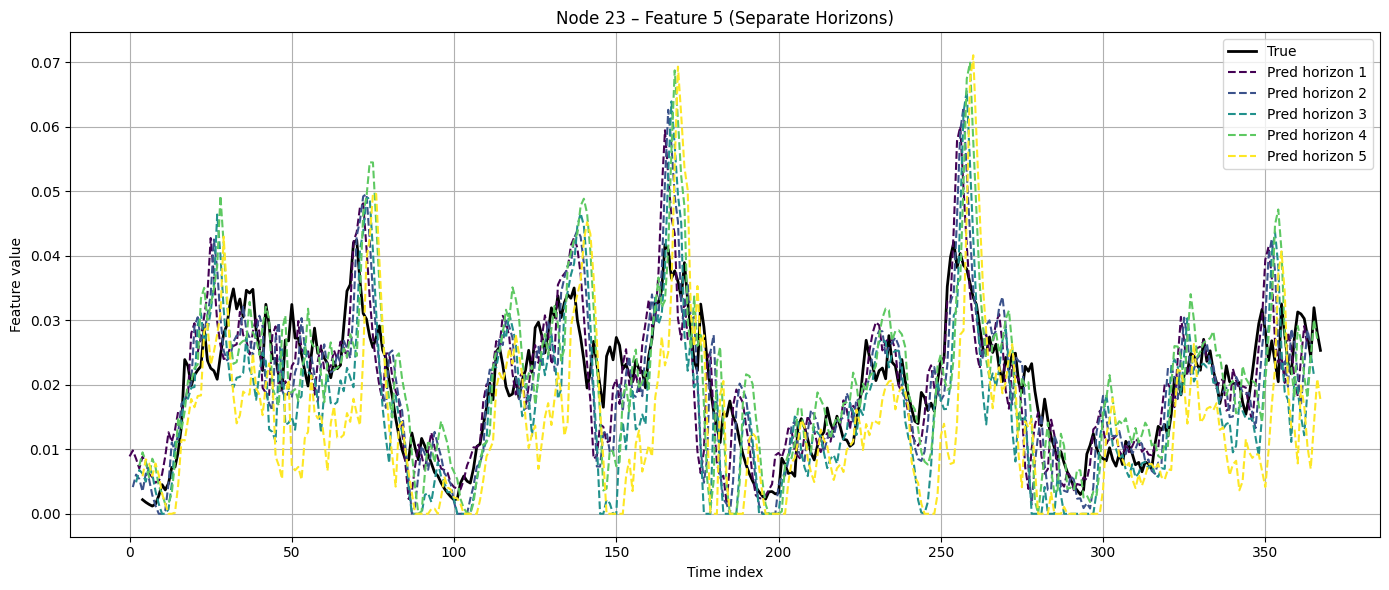

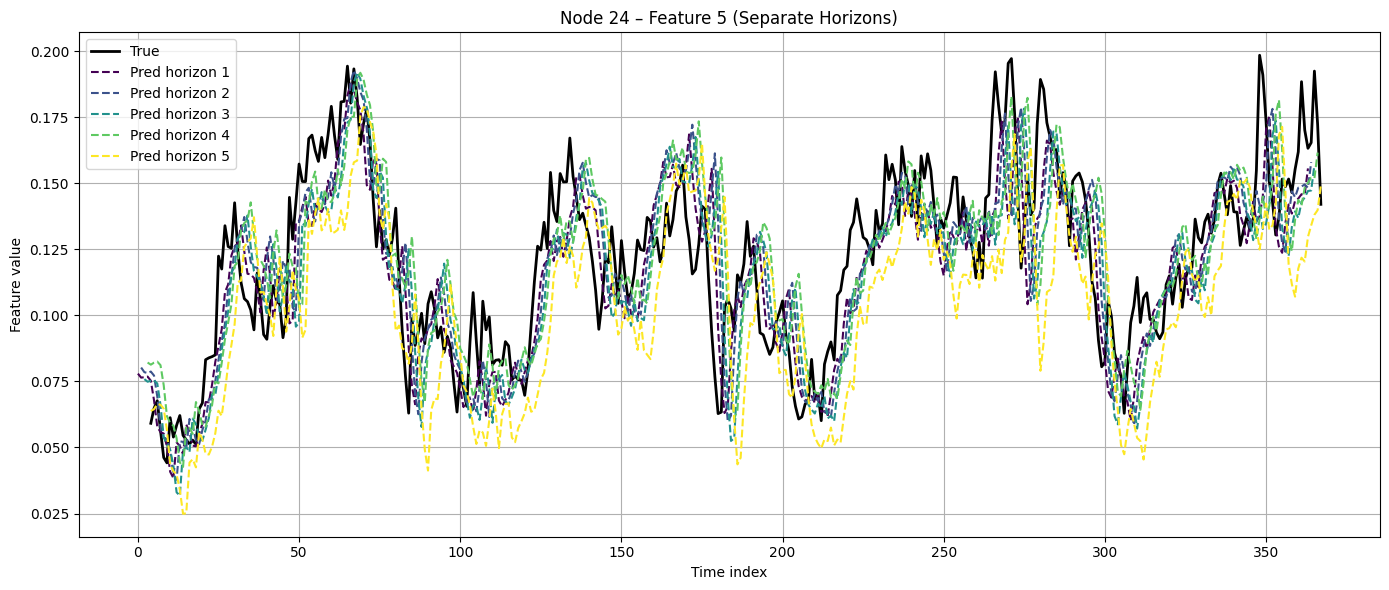

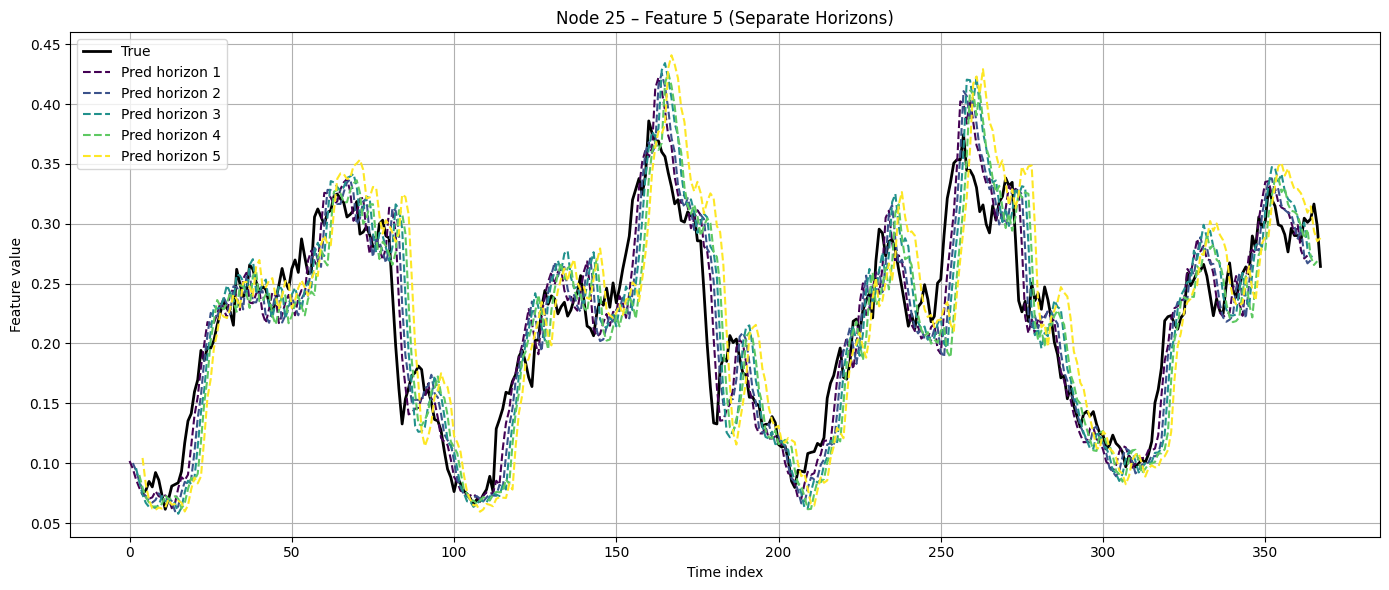

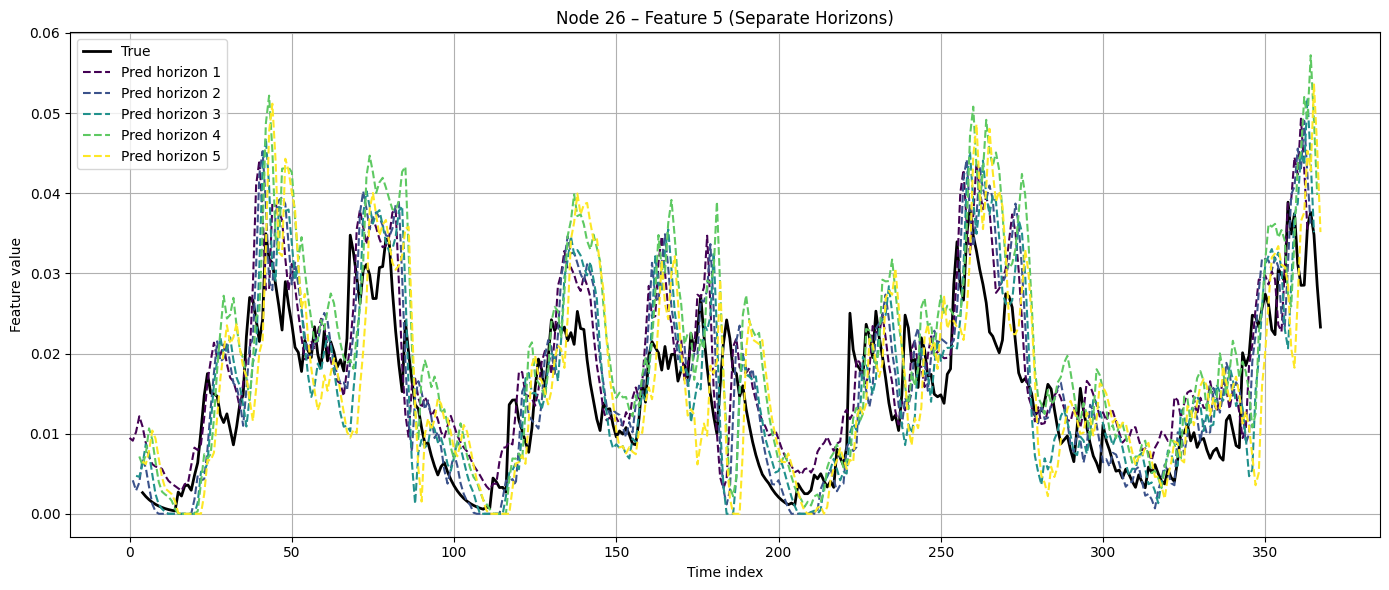

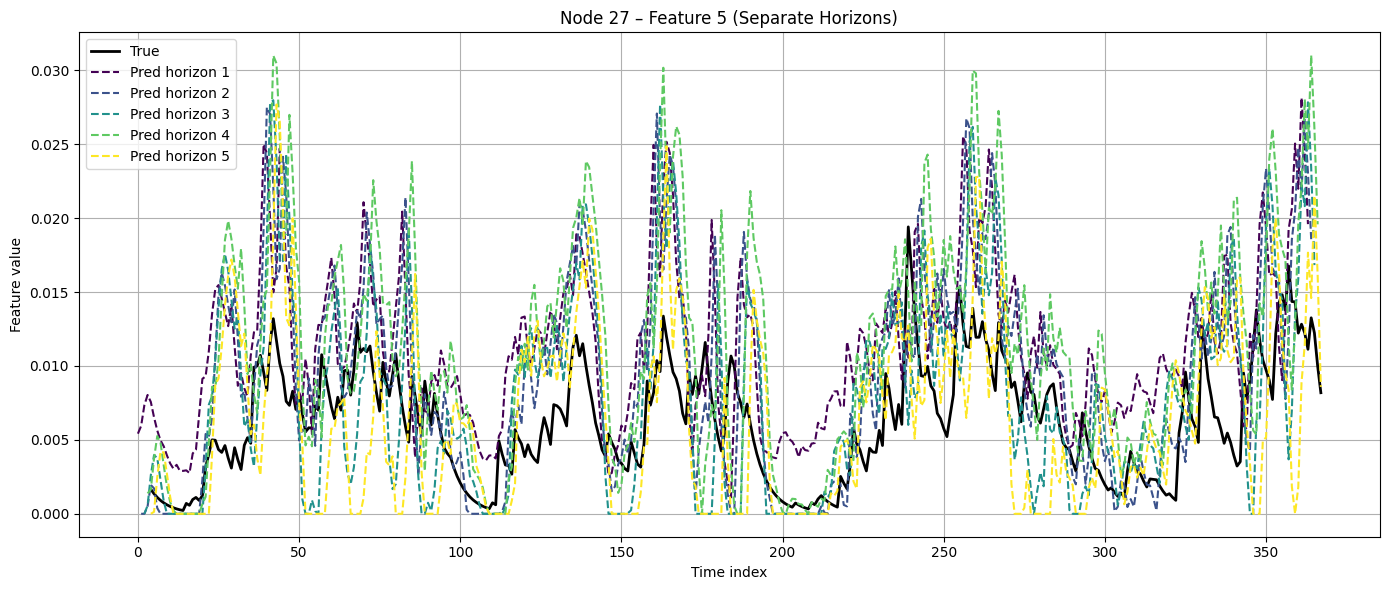

In [56]:
import vis_utils  # your visualization utilities

client_id = 7
round_num = max(all_clients_results[client_id].keys())
results = all_clients_results[client_id][round_num]

# predictions and true values
predictions = results["preds"]       # [B, T_out, N, F]
true_forecast = results["true_pred"] # [B, T_out, N, F]

# --- Skip horizon 1 and relabel others ---
# Keep only horizons from index 1 onwards
predictions = predictions[:, 1:, :, :]
true_forecast = true_forecast[:, 1:, :, :]

# Choose nodes to visualize (excluding missing)
N = predictions.shape[2]
missing_indexes = subgraphs_with_masks[client_id][3]  # missing nodes
concerned_nodes = [node for node in range(N) if node not in missing_indexes]

# Feature to visualize (emissions)
feature_idx = 5

# Plot
vis_utils.plot_node_inference_curves(
    all_trueimpute=true_forecast, 
    all_imputes=predictions, 
    concerned_nodes=concerned_nodes, 
    feature_index=feature_idx
)

